# 본 코드는 "딥러닝을 위한 파이토치 입문" 책을 참고했습니다.

### 인공 신경망

인공 신경망은 사람의 신경망을 모사하여 만든 예측 도구이다. 기본적으로 하나의 레이어에 다수의 노드를 가지고 있으며 여러 개의 레이어가 쌓인 신경망을
깊은 신경망이라고 한다. 이 때, 깊은 신경망을 이용하여 모델을 학습 시키는 방법을 딥러닝이라고 한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

## 4.1 데이터 불러오기

In [3]:
PATH = '/content/drive/MyDrive/Pytorch Basic/deeplearningbro/pytorch/data/reg.csv'

In [4]:
df = pd.read_csv(PATH, index_col=[0])

In [5]:
# 데이터프레임 보여주기
# df.head()는 상위 5줄만 보여준다.
# df.head(10) 괄호 안에 숫자 10을 넣으면 10줄을 보여준다. 
df.head(5) 

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333


In [6]:
len(df)

506

## 4.2 데이터 변수와 타겟값 나누기

In [7]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

In [8]:
print(X.shape)
print(Y.shape)

(506, 13)
(506, 1)


## 4.3 텐서 데이터와 배치 만들기

In [9]:
# 텐서 데이터로 변환하는 클래스(3강 참고)
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [10]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [11]:
# 13개의 변수를 가지고 있는 X 데이터
X_train[:2]

array([[0.04799781, 0.22107091, 0.20689885, 0.39252659, 0.39118033,
        0.75030748, 0.51279589, 0.24069266, 0.18220784, 0.14757058,
        0.08612577, 0.97934246, 0.04527046],
       [0.02792843, 0.88520879, 0.13562002, 0.25170783, 0.68341568,
        0.54102607, 0.19756215, 0.6938564 , 0.25747974, 0.0767333 ,
        0.47342374, 0.98933757, 0.12924183]])

In [12]:
# 실제 예측을 해야하는 집값을 의미하는 Y 데이터 1개의 데이터
Y_train[:2]

array([[0.85555556],
       [0.67555556]])

In [13]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)

In [14]:
print(trainsets)
type(trainsets)

__main__.TensorData

In [15]:
# 미니 배치 32로, 하나의 미니배치는 32개의 데이터로 구성, 랜덤으로 셔플 on
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

In [16]:
print(trainloader)
print(type(trainsets))

<class '__main__.TensorData'>


In [17]:
testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [18]:
type(X_test)

numpy.ndarray

In [19]:
print(len(trainloader))
print(len(testloader))

8
8


## 4.4 모델 구축

모델은 Regressor로 정의하며 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다. 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [20]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x

# 집값의 경우 -가 없는 값이기 때문에 relu를 사용했다.    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

## 4.5 모델, 손실함수, 최적화 방법 선언

In [21]:
model = Regressor()
criterion = nn.MSELoss()

# lr은 학습률이다.
# weight_decay는 L2 정규화에서의 penalty 정도를 의미한다.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

## 4.6 학습 진행

In [22]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader)

for epoch in range(400): # 400번 학습을 진행한다.

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 

    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

        
print('Finished Training')

Finished Training


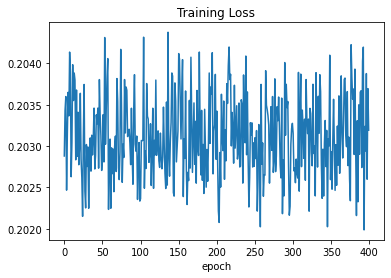

In [23]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 4.7 모델 평가

In [24]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다. dropout의 적용을 없애준다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값을 누적 마지막 0은 행 기준으로 하나씩 쌓겠다는뜻
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적
    
    predictions = predictions.numpy() # 넘파이 배열로 변경
    actual = actual.numpy() # 넘파이 배열로 변경
    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [25]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 20번의 평가 결과의 평균으로 결과값을 산정 했습니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.45068604
Test RMSE:  0.42879328


## Git commit

In [26]:
cd/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic

/content/drive/MyDrive/Git_link/Deeplearning/pytorch_basic


In [27]:
!git config --global user.email "injaeda7@gmail.com"
!git config --global user.name "SEOINJAE"

In [28]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/SEOINJAE/Deeplearning
   6b89670..bfa7492  master     -> origin/master
Updating 6b89670..bfa7492
Fast-forward
 pytorch_basic/4-1.Neural Networks.ipynb | 1 -
 1 file changed, 1 deletion(-)
 delete mode 100644 pytorch_basic/4-1.Neural Networks.ipynb


In [29]:
!git add .

In [30]:
!git commit -m "chapter 1 done"

[master 4e9b607] chapter 4 done
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite "pytorch_basic/1.Neural Networks(\341\204\207\341\205\251\341\204\211\341\205\263\341\204\220\341\205\245\341\206\253 \341\204\214\341\205\265\341\206\270\341\204\200\341\205\241\341\206\271 \341\204\213\341\205\250\341\204\216\341\205\263\341\206\250).ipynb" (99%)


In [31]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 859 bytes | 214.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SEOINJAE/Deeplearning.git
   bfa7492..4e9b607  master -> master
